In [1]:
import pandas as pd
import numpy as np
import nltk

from itertools import chain
from nltk import clean_html, sent_tokenize, word_tokenize
from nltk.probability import ConditionalFreqDist
from nltk.draw import dispersion_plot

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
#Read in the full corpus 
corpus_df = pd.read_csv('../FullCorpus/Abstracts_formatted_all.txt',header=None)
data = corpus_df.values
data = data.flatten()
print np.shape(data)

(6196,)


In [3]:
corpus_df['docNum'] = range(0,len(data))
corpus_df['docs'] = data

data_tokenized = []
for doc in corpus_df.docs:
    tokenized_text = word_tokenize(doc)
    data_tokenized.append(tokenized_text)

corpus_df['tokenDocs'] = data_tokenized

In [4]:
#join into a single block
all_text = ' '.join([doc for doc in data])
# tokenize text into sentences, sentences into words
tokenized_text = [word_tokenize(sent) for sent in sent_tokenize(all_text)]
# flatten list of lists into a single words list
all_words = list(chain(*tokenized_text))

In [5]:
fdist = nltk.FreqDist(all_words)

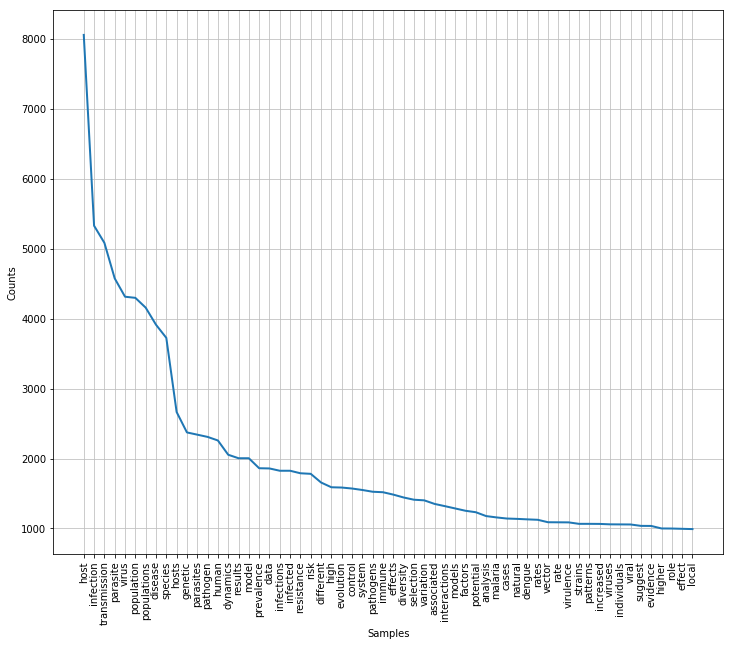

In [6]:
figure(figsize=(12,10))
fdist.plot(60,cumulative=False)

In [65]:
#conditional frequencies:
pair_list = []

nchunk = 100
nyear = len(data)/nchunk +1


totalWords = np.zeros(nyear)
kk = 0
for num in corpus_df.docNum:
    document = corpus_df.loc[corpus_df['docNum']==num]['tokenDocs'].values
    year = num/nchunk
    nword = 0
    for word in document[0]:
        pair_list.append([year,word])
        nword += 1
    totalWords[year] += nword
    
fullFreqDist = ConditionalFreqDist(pair_list) 

In [66]:
toplot = []
word = 'zika'
for y in range(nyear):
    toplot.append(fullFreqDist[y][word])

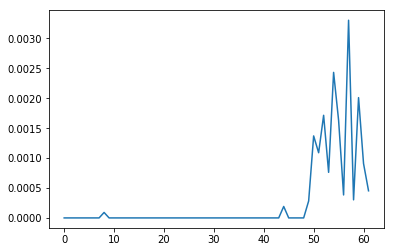

In [67]:
plt.plot(toplot/totalWords)


In [10]:
def subjectFreqPlot(fdist,subject_list,nyear):
    fullplot = np.zeros(nyear)
    for word in subject_list:
        toplot = []
        for y in range(nyear):
            toplot.append(fdist[y][word])
        
        fullplot += np.array(toplot)
    
    return fullplot

In [11]:
hantalist = ['hanta', 'hantavirus', 'hantaviruses', 'hps']
hantaplot = subjectFreqPlot(freqDist,hantalist,nyear)

climatelist = ['climate','weather','temperature','warming']
climateplot = subjectFreqPlot(freqDist,climatelist,nyear)

mosquitolist = ['mosquito','aedes','vector','nile','west','wnv','malaria']
mosquitoplot = subjectFreqPlot(freqDist,mosquitolist,nyear)

vacclist = ['vaccine', 'vaccination', 'vaccinate', 'campaign', 'immunity']
vaccplot = subjectFreqPlot(freqDist,vacclist,nyear)

humanlist = ['children','measles','zika','human','malaria','polio','ebola','vaccination']
humanplot = subjectFreqPlot(freqDist,humanlist,nyear)

kezlist = ['sheep', 'bighorn', 'pneumonia', 'ovine']
kezplot = subjectFreqPlot(freqDist,kezlist,nyear)

spacelist = ['spatial','space','network','movement']
spaceplot = subjectFreqPlot(freqDist,spacelist,nyear)

hivlist = ['hiv','aids','immunodeficiency']
hivplot = subjectFreqPlot(freqDist,hivlist,nyear)

testlist = ['cull']
testplot = subjectFreqPlot(freqDist,testlist,nyear)

In [12]:
#Use the clusters from tSne to make lists. eg:

cluster27list = ['dengue','background','virus','transmission','fever','vector','disease','climate','cases',\
                 'mosquito']
cluster27plot = subjectFreqPlot(freqDist,cluster27list,nyear)

cluster0list = ['mice','deer','hantavirus','snv','prevalence','mouse','nombre','sin','infection','virus']
cluster0plot = subjectFreqPlot(freqDist,cluster0list,nyear)

aidsclusterlist = ['hiv','immunodeficiency','antiretroviral','aids']
aidsclusterplot = subjectFreqPlot(freqDist,aidsclusterlist,nyear)

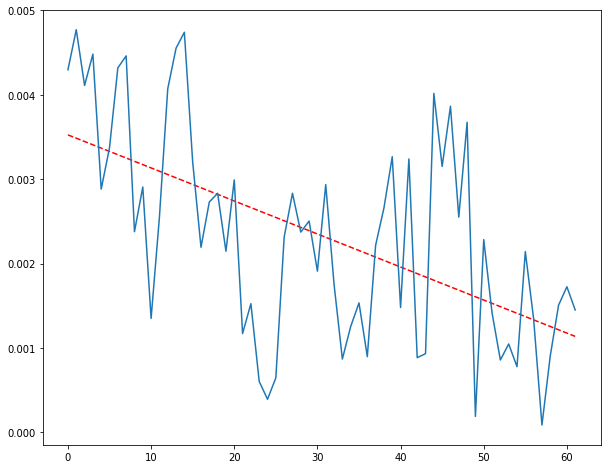

In [13]:
figure(figsize=(10,8))

xtoplot = range(nyear)
ytoplot = aidsclusterplot/totalWords
z = np.polyfit(xtoplot, ytoplot , 1)
p = np.poly1d(z)
plt.plot(xtoplot,p(xtoplot),"r--")
plt.plot(ytoplot)

#plt.savefig('hanta_freq_II.png')

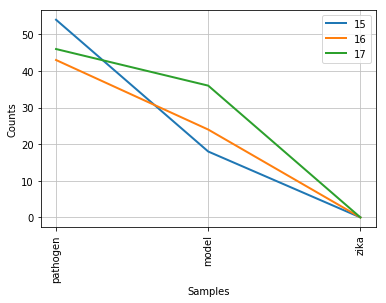

In [14]:
freqDist.plot(conditions=[15,16,17],samples=['pathogen','model','zika'])

In [15]:
#calculation of dispersion measures.

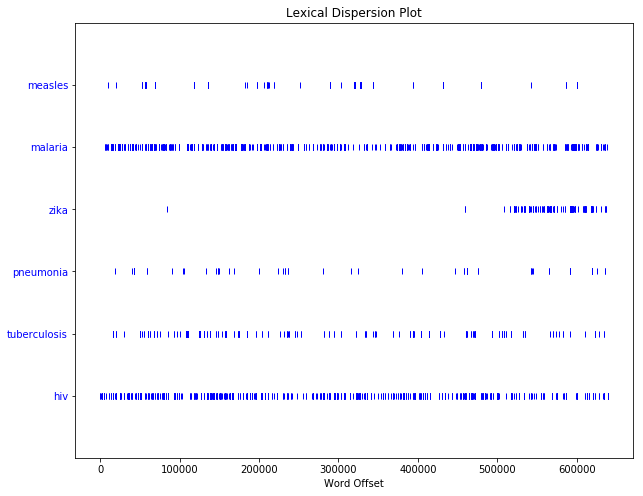

In [16]:
figure(figsize=(10,8))
dispersion_plot(all_words,
                ['measles', 'malaria', 'zika', 'pneumonia','tuberculosis','hiv'],
                ignore_case=True)

In [35]:
#Ok. What statistic are you going to calculate? And for what words? First, get the words listed by frequency.
fdist = nltk.FreqDist(all_words)

In [43]:
worddict = {}
wordList = []
for a in fdist:
    worddict[a] = fdist[a]
    wordList.append([a,fdist[a]])
wordList = np.array(wordList)
wordList[:,1] = wordList[:,1].astype(float)
np.shape(wordList)

(25477, 2)

In [108]:
mcWords = fdist.most_common(6000)

In [109]:
s = totalWords/np.sum(totalWords)

In [110]:
j = 0
DParray = np.zeros(len(mcWords))
wcarray = np.zeros(len(mcWords))
for a in mcWords:
    word = a[0]
    wcount = fdist.freq(word)*fdist.N()
    wcarray[j] = wcount
    DP = 0.
    for i in range(nyear):
        f = fullFreqDist[i][word]/wcount
        DP += np.abs(s[i] - f)/2.
    DParray[j] = DP
    j += 1

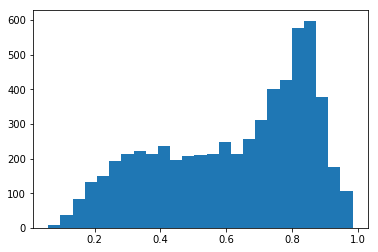

In [111]:
a,b,c = plt.hist(DParray,bins=25)

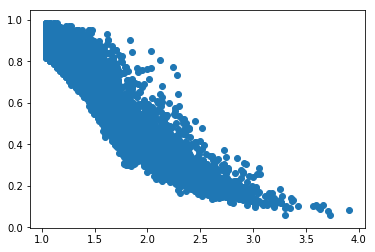

In [112]:
plt.scatter(np.log10(wcarray),DParray)

In [113]:
#Next: automatic key phrase extraction
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string
    
    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda (word,pos,chunk): chunk != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]

In [121]:
for i in range(10):
    test = extract_candidate_chunks(data[150+i])
    print test

['defective antifungal activity macrophages human immunodeficiency children invasive aspergillosis', 'adults children human immunodeficiency virus hiv infection', 'risk factors', 'corticosteroid therapy macrophages', 'role host defenses', 'conidia', 'germination hyphae antifungal activity peripheral blood macrophages', 'children', 'normal controls phagocytic activity patients', 'percentage phagocytosis', 'normal donors addition inhibitory activity mdm germination intracellular fumigatus conidia', 'patients', 'normal controls difference defects patients', 'lymphocyte counts impairment antifungal activity macrophages', 'susceptibility patients aspergillosis']
['insight infection dynamics', 'epidemic birth cohort analysis aids mortality authors', 'secular trends', 'city', 'immunodeficiency syndrome aids mortality quarter birth cohort techniques', 'insight reasons temporal changes growth', 'aids mortality data composite birth cohorts authors', 'growth epidemic result', 'decline aids deaths

In [120]:
def extract_candidate_words(text, good_tags=set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates

In [122]:
for i in range(50):
    test = extract_candidate_words(data[150+i])
    print test

['defective', 'antifungal', 'activity', 'macrophages', 'human', 'immunodeficiency', 'children', 'invasive', 'aspergillosis', 'adults', 'children', 'human', 'immunodeficiency', 'virus', 'hiv', 'infection', 'risk', 'factors', 'corticosteroid', 'therapy', 'macrophages', 'role', 'host', 'defenses', 'organisms', 'conidia', 'germination', 'hyphae', 'antifungal', 'activity', 'peripheral', 'blood', 'macrophages', 'children', 'normal', 'controls', 'phagocytic', 'activity', 'patients', 'percentage', 'phagocytosis', 'normal', 'donors', 'addition', 'inhibitory', 'activity', 'mdm', 'germination', 'intracellular', 'fumigatus', 'conidia', 'patients', 'normal', 'controls', 'difference', 'defects', 'patients', 'lower', 'higher', 'lymphocyte', 'counts', 'impairment', 'antifungal', 'activity', 'macrophages', 'susceptibility', 'patients', 'aspergillosis']
['insight', 'infection', 'dynamics', 'epidemic', 'birth', 'cohort', 'analysis', 'aids', 'mortality', 'authors', 'secular', 'trends', 'city', 'immunodefi

In [123]:
#This may perform better if we do less pre-processing? I've already pulled everything out that's not the parts
#of speech that they're looking for.
corpus_min_df = pd.read_csv('../FullCorpus/Abstracts_formatted_all.txt',header=None)
datamin = corpus_min_df.values
datamin = data.flatten()
print np.shape(datamin)

(6196,)


In [125]:
for i in range(50):
    test = extract_candidate_chunks(datamin[150+i])
    print test

['defective antifungal activity macrophages human immunodeficiency children invasive aspergillosis', 'adults children human immunodeficiency virus hiv infection', 'risk factors', 'corticosteroid therapy macrophages', 'role host defenses', 'conidia', 'germination hyphae antifungal activity peripheral blood macrophages', 'children', 'normal controls phagocytic activity patients', 'percentage phagocytosis', 'normal donors addition inhibitory activity mdm germination intracellular fumigatus conidia', 'patients', 'normal controls difference defects patients', 'lymphocyte counts impairment antifungal activity macrophages', 'susceptibility patients aspergillosis']
['insight infection dynamics', 'epidemic birth cohort analysis aids mortality authors', 'secular trends', 'city', 'immunodeficiency syndrome aids mortality quarter birth cohort techniques', 'insight reasons temporal changes growth', 'aids mortality data composite birth cohorts authors', 'growth epidemic result', 'decline aids deaths